# Time Series II - Generative Approach

In [1]:
import wooldridge as woo
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from supplementaryFunctions import *

## The Nature of Highly Persistent Time Series

### Random Walk Hypothesis

$$y_t = y_{t-1} + e_t$$

$$ y_t = y_0 + e_1 + e_2 + ... + e_{t-1} + e_t $$

$$Var(y_t|y_0) = \sigma_e^2t$$

Data that is a random walk is a function of the value in the previous periods (as opposed to being drawn from a distribution whose mean is defined by a constant or a line. Rather, the new value is drawn from a distribution $E$ wherek $\bar{E}$ is a constant. Below, we assume $\bar{E}=0$.

In [2]:
x_range = np.linspace(0, 100, num = 101)
simulations = {}

for r in range(1000):
    e = stats.norm.rvs(0,1, size = 101)
    e[0] = 0
    simulations[r] = np.cumsum(e)
simulations = pd.DataFrame(simulations)
simulations.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.256012,-2.011305,-0.415018,-0.697597,-0.544833,-0.425808,-0.959578,-1.946834,-0.310939,-0.239999,...,0.102729,-0.917888,0.044845,-0.225318,-1.608982,1.495504,-1.596267,0.703405,-0.933168,0.818609
2,1.749504,-3.288519,0.095333,-0.025058,-0.342296,-0.477709,-2.247347,-2.312478,-0.436299,-1.317033,...,-0.129869,-0.595331,-0.424336,1.772582,-3.481591,2.665633,0.187901,2.998755,-2.083759,2.472627
3,3.608168,-2.858307,-0.587319,0.113882,0.389037,-0.197544,-3.198283,-2.335040,0.104742,-1.358221,...,1.132550,-1.526326,-0.024266,1.352489,-2.522920,2.722193,2.664366,4.517603,-3.356010,2.245056
4,3.657813,-2.953792,-2.050280,-0.799516,-0.573485,-0.218883,-2.832727,-2.814246,-0.516431,-1.585658,...,1.336230,-2.073934,-0.345268,-0.212368,-4.892039,4.120646,3.164789,5.117226,-2.472712,1.318257


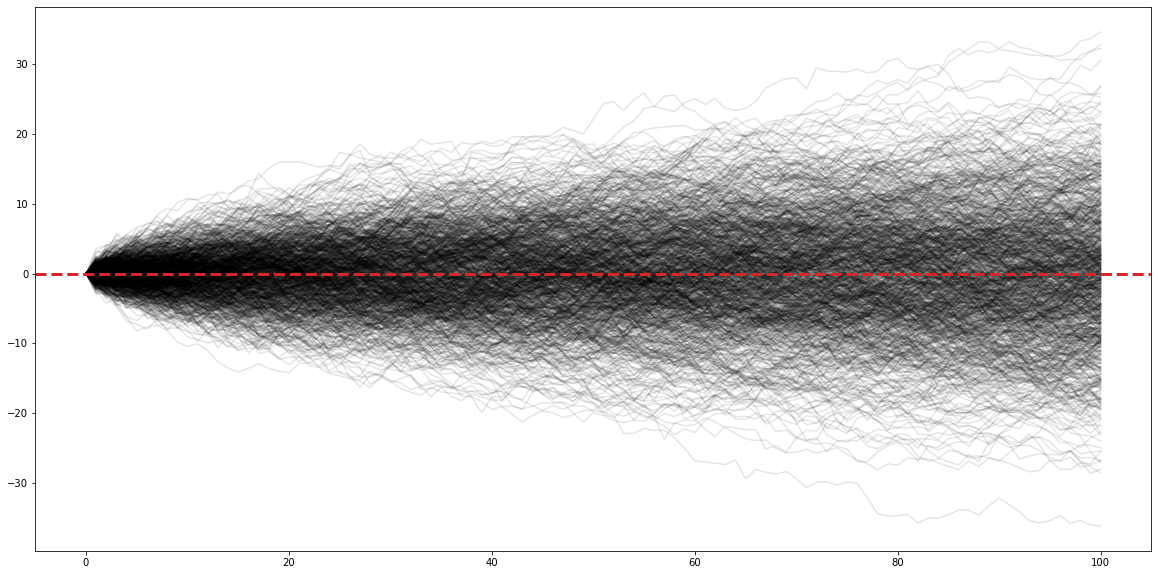

In [3]:
fig, ax = plt.subplots(figsize = (20,10))
simulations.plot.line(alpha = .1, color = "k", ax = ax, legend = False)
ax.axhline(0, ls = "--", color = "C3", linewidth = 3)


### Random Walk with Drift

If that $\bar{E} \ne 0$, the the the function is described as a random walk with drift. We describe $\bar{E}$ as $\alpha_0$.

$$y_t = \alpha_0 + y_{t-1} + e_t$$

$$ y_t = y_0 + \alpha_0t + e_1 + e_2 + ... + e_{t-1} + e_t $$

We can $\bar{E} \ne0$ using OLS regression with a lag. If the value of an observation is simply a function of the past value plus some error, all variation should be explained by the lag term

In [4]:
def monte_carlo_simulation(e_bar = 0, periods = 101, num_simulations = 100):
    x_range = np.linspace(0, periods - 1, 
                          num = periods)
    simulations = {}
    for r in range(num_simulations):
        e = stats.norm.rvs(e_bar, 1, size = periods)
        e[0] = 0
        simulations[r] = np.cumsum(e)
    simulations = pd.DataFrame(simulations)
    return simulations

e_bar = 2
periods = 200
num_simulations = 2000
simulations = monte_carlo_simulation(e_bar = e_bar, 
                                     periods = periods, 
                                     num_simulations = num_simulations)
simulations

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.795441,0.860394,2.610519,0.772404,0.949685,2.680446,2.603616,3.200110,2.081175,1.235662,...,4.922833,2.450021,2.113474,2.425615,2.823165,1.835270,4.309188,1.513663,3.370445,1.615352
2,4.254248,4.603739,4.096428,2.673953,3.039046,4.979369,5.321048,5.212405,3.996128,3.056616,...,6.779946,1.626580,3.306485,4.730315,5.323330,3.557169,5.468047,3.900973,5.129912,3.138209
3,4.402561,5.382050,6.408116,5.629040,4.894234,6.349000,9.137460,7.660826,6.568350,6.465570,...,10.864993,2.891432,5.351916,7.700133,7.293076,5.627297,7.349637,5.622158,5.879188,2.967658
4,6.366456,6.675151,8.025055,8.792425,6.915054,8.041039,9.761739,9.561222,6.613742,7.067457,...,11.935967,6.550001,8.035368,8.608124,10.831738,7.485246,8.235838,6.467186,6.732821,4.790237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,364.874136,405.624229,379.728132,393.066630,391.724633,382.871124,400.003182,405.980912,367.804314,401.531344,...,383.295034,401.463111,405.724406,380.488941,395.692558,363.839149,397.285338,398.776218,369.213829,385.384348
196,366.469714,409.327497,381.859534,395.308966,390.929684,384.634482,401.908089,406.787882,368.892007,405.312795,...,383.469766,403.100458,408.216477,382.458797,397.015401,366.526959,400.291964,399.573611,371.655703,386.922632
197,368.600988,411.900505,384.986654,398.408997,393.708167,384.927752,404.430364,407.879791,370.001179,407.110108,...,384.748961,405.355369,410.888807,382.265503,399.075090,368.435332,403.192472,402.436737,374.960240,387.979443
198,371.122638,413.285923,387.277357,400.981161,396.239607,385.876870,406.683228,408.914533,371.598787,409.599213,...,387.740883,408.048270,412.819878,386.460696,401.279180,369.326645,405.505481,405.846397,375.398027,387.771505


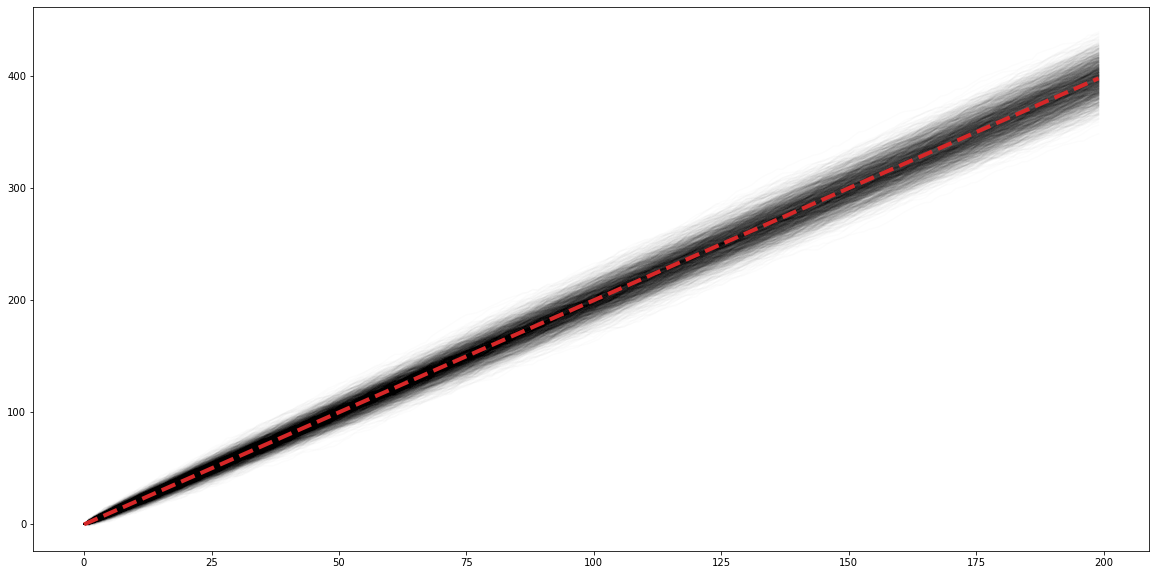

In [5]:
fig, ax = plt.subplots(figsize = (20,10))
simulations.plot.line(alpha = .01, 
                      color = "k", 
                      ax = ax, 
                      legend = False)
ax.plot(np.arange(periods), np.arange(periods) * e_bar, ls = "--", color = "C3", linewidth = 4)


### Unit Root in Artificial Data

In [6]:
simulations.rename(columns = {i:"Simulation" + str(i) for i in simulations.keys()}, inplace = True)
results = {}
for i in simulations:
    formula = i + " ~ " + i + ".shift(1) + 1"
    reg = smf.ols(formula = formula,
        data =simulations)
    results[i] = reg.fit()
    print(OLS_summary(results[i]))


                      $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                             
Intercept               1.7352    11.8946        0.0  0.1459
Simulation0.shift(1)    1.0008  1437.2929        0.0  0.0007
                      $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                             
Intercept               2.2098    14.5830        0.0  0.1515
Simulation1.shift(1)    0.9995  1598.2577        0.0  0.0006
                      $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                             
Intercept               1.8757    13.5046        0.0  0.1389
Simulation2.shift(1)    1.0004  1591.0748        0.0  0.0006
                      $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                             
Intercept               1.9686    13.8403        0.0  0.1422
Simulation3.shift(1)    1.0003  1619.0655        0.0  0.0006
                      $\

                       $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                              
Intercept                1.8524    12.7428        0.0  0.1454
Simulation62.shift(1)    1.0005  1525.2213        0.0  0.0007
                       $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                              
Intercept                1.8893    12.5296        0.0  0.1508
Simulation63.shift(1)    1.0004  1466.7045        0.0  0.0007
                       $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                              
Intercept                2.0079    14.1991        0.0  0.1414
Simulation64.shift(1)    1.0002  1646.9490        0.0  0.0006
                       $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                              
Intercept                2.0456    14.5914        0.0  0.1402
Simulation65.shift(1)    0.9994  1603.7632        0.0  0.0006
        

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9282    12.7650        0.0  0.1511
Simulation127.shift(1)    1.0003  1497.0275        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1279    14.9855        0.0  0.1420
Simulation128.shift(1)    0.9995  1649.4681        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0315    14.0365        0.0  0.1447
Simulation129.shift(1)    1.0001  1612.1776        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.8929    13.2282        0.0  0.1431
Simulation130.shift(1)    1.0008  1606.9749        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                  1.988    13.9198        0.0  0.1428
Simulation192.shift(1)     1.000  1580.5738        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.3233    16.2771        0.0  0.1427
Simulation193.shift(1)    0.9991  1746.9741        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9595    14.7253        0.0  0.1331
Simulation194.shift(1)    0.9995  1615.5090        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9151    13.0455        0.0  0.1468
Simulation195.shift(1)    1.0007  1579.4690        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1015    14.7519        0.0  0.1425
Simulation258.shift(1)    0.9996  1644.3186        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0372    13.6641        0.0  0.1491
Simulation259.shift(1)    0.9999  1553.4304        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9505    15.2597        0.0  0.1278
Simulation260.shift(1)    1.0006  1821.1723        0.0  0.0005
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9929    13.4190        0.0  0.1485
Simulation261.shift(1)    0.9999  1508.2116        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.8543    12.8189        0.0  0.1447
Simulation292.shift(1)    1.0006  1534.3158        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0427    15.5922        0.0  0.1310
Simulation293.shift(1)    1.0005  1842.8709        0.0  0.0005
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9829    13.9164        0.0  0.1425
Simulation294.shift(1)    1.0003  1630.6413        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.7695    12.5506        0.0  0.1410
Simulation295.shift(1)    1.0010  1542.5518        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9766    14.3007        0.0  0.1382
Simulation325.shift(1)    0.9997  1597.1265        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9053    13.1987        0.0  0.1444
Simulation326.shift(1)    1.0005  1571.8008        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0600    13.5308        0.0  0.1522
Simulation327.shift(1)    0.9997  1514.7521        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9141    13.3048        0.0  0.1439
Simulation328.shift(1)    1.0004  1561.1103        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9406    12.4757        0.0  0.1556
Simulation359.shift(1)    0.9995  1369.7033        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1486    14.9523        0.0  0.1437
Simulation360.shift(1)    0.9994  1640.3352        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9657    14.5243        0.0  0.1353
Simulation361.shift(1)    1.0002  1696.2348        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9630    13.7046        0.0  0.1432
Simulation362.shift(1)    0.9996  1518.8609        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9052    14.6521        0.0  0.1300
Simulation420.shift(1)    1.0002  1704.3412        0.0  0.0006
                        $\beta $       $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                              
Intercept                 2.1381    15.148        0.0  0.1411
Simulation421.shift(1)    0.9992  1635.181        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.2123    14.6982        0.0  0.1505
Simulation422.shift(1)    0.9992  1577.0950        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9846    15.6744        0.0  0.1266
Simulation423.shift(1)    1.0004  1852.7413        0.0  0.0

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.2019    16.4045        0.0  0.1342
Simulation482.shift(1)    0.9992  1764.4611        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1583    15.5154        0.0  0.1391
Simulation483.shift(1)    0.9993  1685.3945        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.2718    16.9645        0.0  0.1339
Simulation484.shift(1)    0.9995  1857.1631        0.0  0.0005
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.2216    15.4225        0.0  0.1441
Simulation485.shift(1)    0.9993  1660.8378        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.8381    13.8494        0.0  0.1327
Simulation544.shift(1)    1.0008  1696.6501        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0276    13.0976        0.0  0.1548
Simulation545.shift(1)    0.9996  1445.1970        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0882    15.2481        0.0  0.1369
Simulation546.shift(1)    0.9998  1721.7469        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9937    13.2428        0.0  0.1506
Simulation547.shift(1)    1.0000  1507.4305        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1650    14.9984        0.0  0.1443
Simulation605.shift(1)    0.9993  1637.0362        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0239    14.6138        0.0  0.1385
Simulation606.shift(1)    1.0003  1712.3155        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9083    13.6128        0.0  0.1402
Simulation607.shift(1)    1.0008  1655.4849        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.7430    12.7565        0.0  0.1366
Simulation608.shift(1)    1.0012  1603.2472        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.7504    12.9579        0.0  0.1351
Simulation641.shift(1)    1.0008  1572.1454        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.8826    12.8917        0.0  0.1460
Simulation642.shift(1)    1.0003  1501.4799        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9742    14.0487        0.0  0.1405
Simulation643.shift(1)    1.0001  1612.9296        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0560    15.2751        0.0  0.1346
Simulation644.shift(1)    1.0001  1752.3119        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9926    14.2938        0.0  0.1394
Simulation697.shift(1)    1.0002  1664.1595        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9415    13.2315        0.0  0.1467
Simulation698.shift(1)    1.0008  1602.0424        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.8482    12.4402        0.0  0.1486
Simulation699.shift(1)    1.0002  1441.8385        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9696    13.9251        0.0  0.1414
Simulation700.shift(1)    1.0004  1649.8490        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.7897    12.8857        0.0  0.1389
Simulation749.shift(1)    1.0013  1627.2293        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1043    14.4219        0.0  0.1459
Simulation750.shift(1)    0.9994  1573.2808        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0350    14.6459        0.0  0.1389
Simulation751.shift(1)    0.9993  1579.9848        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1722    15.8987        0.0  0.1366
Simulation752.shift(1)    0.9995  1757.9144        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1826    16.3370        0.0  0.1336
Simulation803.shift(1)    0.9995  1804.8157        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0515    14.5993        0.0  0.1405
Simulation804.shift(1)    0.9995  1616.6581        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.9930    15.1567        0.0  0.1315
Simulation805.shift(1)    0.9997  1714.3861        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0420    14.1750        0.0  0.1441
Simulation806.shift(1)    0.9997  1585.0006        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0898    15.4548        0.0  0.1352
Simulation855.shift(1)    0.9999  1756.4992        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.8086    13.2238        0.0  0.1368
Simulation856.shift(1)    1.0004  1560.0419        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.8037    14.0810        0.0  0.1281
Simulation857.shift(1)    1.0007  1707.2649        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1177    15.3481        0.0  0.1380
Simulation858.shift(1)    0.9989  1613.1163        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.8537    11.9673        0.0  0.1549
Simulation911.shift(1)    1.0008  1437.9194        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.0265    14.2166        0.0  0.1425
Simulation912.shift(1)    1.0001  1630.4341        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.2066    15.7385        0.0  0.1402
Simulation913.shift(1)    0.9988  1646.0605        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 1.6878    12.5197        0.0  0.1348
Simulation914.shift(1)    1.0010  1533.8699        0.0 

                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.2122    17.3452        0.0  0.1275
Simulation966.shift(1)    0.9995  1911.7772        0.0  0.0005
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1162    14.1661        0.0  0.1494
Simulation967.shift(1)    0.9995  1562.9913        0.0  0.0006
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1485    14.0239        0.0  0.1532
Simulation968.shift(1)    0.9991  1487.0730        0.0  0.0007
                        $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                               
Intercept                 2.1872    15.0799        0.0  0.1450
Simulation969.shift(1)    0.9994  1654.9729        0.0 

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.2417    16.4865        0.0  0.1360
Simulation1022.shift(1)    0.9997  1855.4074        0.0  0.0005
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9018    13.2056        0.0  0.1440
Simulation1023.shift(1)    1.0001  1535.0123        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1634    16.4313        0.0  0.1317
Simulation1024.shift(1)    0.9998  1859.8541        0.0  0.0005
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9784    15.0039        0.0  0.1319
Simulation1025.shift(1)    0.9992  1616.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.7876    12.6131        0.0  0.1417
Simulation1079.shift(1)    1.0005  1503.3560        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0184    14.2690        0.0  0.1415
Simulation1080.shift(1)    0.9997  1593.7954        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9937    13.4355        0.0  0.1484
Simulation1081.shift(1)    0.9999  1518.4535        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0009    14.7177        0.0  0.1360
Simulation1082.shift(1)    0.9999  1674.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.8418    13.1090        0.0  0.1405
Simulation1141.shift(1)    1.0009  1601.1046        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.8628    13.4023        0.0  0.1390
Simulation1142.shift(1)    1.0008  1632.5403        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.8462    12.4313        0.0  0.1485
Simulation1143.shift(1)    1.0006  1484.1805        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.8842    13.8240        0.0  0.1363
Simulation1144.shift(1)    1.0005  1641.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.2237    17.0759        0.0  0.1302
Simulation1194.shift(1)    0.9991  1823.5253        0.0  0.0005
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1233    15.2142        0.0  0.1396
Simulation1195.shift(1)    0.9996  1687.2304        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0788    15.0969        0.0  0.1377
Simulation1196.shift(1)    0.9997  1687.5628        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9322    13.6518        0.0  0.1415
Simulation1197.shift(1)    1.0007  1638.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.3785    16.1185        0.0  0.1476
Simulation1247.shift(1)    0.9984  1641.2489        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0804    14.5835        0.0  0.1427
Simulation1248.shift(1)    0.9991  1563.0144        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0811    15.2198        0.0  0.1367
Simulation1249.shift(1)    1.0000  1740.2337        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0608    14.3762        0.0  0.1433
Simulation1250.shift(1)    1.0001  1647.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.8763    13.1039        0.0  0.1432
Simulation1303.shift(1)    1.0007  1580.2887        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0751    13.7177        0.0  0.1513
Simulation1304.shift(1)    0.9998  1545.7616        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                   2.019    13.8423        0.0  0.1459
Simulation1305.shift(1)     1.000  1580.2987        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.2139    16.1328        0.0  0.1372
Simulation1306.shift(1)    0.9992  1737.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.2264    15.9095        0.0  0.1399
Simulation1356.shift(1)    0.9998  1800.8245        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.8234    13.0447        0.0  0.1398
Simulation1357.shift(1)    1.0010  1613.3889        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9531    12.2451        0.0  0.1595
Simulation1358.shift(1)    1.0003  1418.3828        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9602    13.1009        0.0  0.1496
Simulation1359.shift(1)    0.9999  1487.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9968    12.8850        0.0  0.1550
Simulation1413.shift(1)    1.0002  1496.1135        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0332    15.5550        0.0  0.1307
Simulation1414.shift(1)    0.9998  1748.7569        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.8391    13.4378        0.0  0.1369
Simulation1415.shift(1)    1.0004  1572.4483        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1196    13.8713        0.0  0.1528
Simulation1416.shift(1)    1.0000  1582.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1486    15.7289        0.0  0.1366
Simulation1465.shift(1)    1.0000  1806.5790        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0097    13.7733        0.0  0.1459
Simulation1466.shift(1)    1.0000  1579.2991        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1727    13.6028        0.0  0.1597
Simulation1467.shift(1)    0.9989  1429.5625        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.2562    16.4364        0.0  0.1373
Simulation1468.shift(1)    0.9992  1773.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.8936    13.4600        0.0  0.1407
Simulation1520.shift(1)    1.0004  1583.2399        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9482    14.0430        0.0  0.1387
Simulation1521.shift(1)    1.0003  1644.4735        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9032    11.7977        0.0  0.1613
Simulation1522.shift(1)    1.0004  1391.7094        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9084    13.7781        0.0  0.1385
Simulation1523.shift(1)    0.9999  1567.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0693    14.8638        0.0  0.1392
Simulation1578.shift(1)    1.0001  1723.3554        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.8963    13.5148        0.0  0.1403
Simulation1579.shift(1)    1.0002  1562.6651        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.2038    17.1693        0.0  0.1284
Simulation1580.shift(1)    0.9996  1907.5301        0.0  0.0005
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.8941    14.1141        0.0  0.1342
Simulation1581.shift(1)    1.0002  1629.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9725    14.3585        0.0  0.1374
Simulation1636.shift(1)    1.0005  1707.5818        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.7749    13.4852        0.0  0.1316
Simulation1637.shift(1)    1.0005  1599.7055        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0582    15.0575        0.0  0.1367
Simulation1638.shift(1)    0.9995  1675.7371        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0255    14.4949        0.0  0.1397
Simulation1639.shift(1)    0.9998  1651.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1346    14.1906        0.0  0.1504
Simulation1695.shift(1)    0.9994  1545.7941        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1801    15.3303        0.0  0.1422
Simulation1696.shift(1)    0.9991  1636.2096        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1029    14.9778        0.0  0.1404
Simulation1697.shift(1)    0.9994  1639.4707        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0339    15.2395        0.0  0.1335
Simulation1698.shift(1)    0.9999  1725.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9573    13.7381        0.0  0.1425
Simulation1755.shift(1)    1.0001  1583.5227        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0912    13.6209        0.0  0.1535
Simulation1756.shift(1)    0.9995  1487.4132        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.2284    16.5783        0.0  0.1344
Simulation1757.shift(1)    0.9991  1785.2634        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9482    13.1329        0.0  0.1483
Simulation1758.shift(1)    1.0001  1509.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1633    14.5554        0.0  0.1486
Simulation1815.shift(1)    0.9997  1638.6013        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9820    12.5147        0.0  0.1584
Simulation1816.shift(1)    0.9996  1380.3633        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.8302    12.9260        0.0  0.1416
Simulation1817.shift(1)    1.0008  1575.4513        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0071    14.3430        0.0  0.1399
Simulation1818.shift(1)    0.9999  1623.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.8114    13.7574        0.0  0.1317
Simulation1875.shift(1)    1.0010  1689.5825        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9978    13.8364        0.0  0.1444
Simulation1876.shift(1)    1.0003  1615.1434        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0069    14.9063        0.0  0.1346
Simulation1877.shift(1)    1.0000  1711.2207        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9502    13.9366        0.0  0.1399
Simulation1878.shift(1)    1.0002  1612.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9668    13.1184        0.0  0.1499
Simulation1935.shift(1)    0.9992  1416.4048        0.0  0.0007
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.9428    15.0007        0.0  0.1295
Simulation1936.shift(1)    1.0002  1740.9570        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0410    15.1996        0.0  0.1343
Simulation1937.shift(1)    0.9991  1637.2017        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1415    14.8375        0.0  0.1443
Simulation1938.shift(1)    0.9997  1673.

                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.0211    14.9103        0.0  0.1356
Simulation1972.shift(1)    0.9999  1696.1188        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  1.8169    13.4592        0.0  0.1350
Simulation1973.shift(1)    1.0007  1616.8579        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.1014    15.4229        0.0  0.1363
Simulation1974.shift(1)    0.9997  1737.6699        0.0  0.0006
                         $\beta $        $t$  $$P>|t|$$    $SE$
$$r^2: 0.9999$$                                                
Intercept                  2.2378    16.1299        0.0  0.1387
Simulation1975.shift(1)    0.9992  1747.

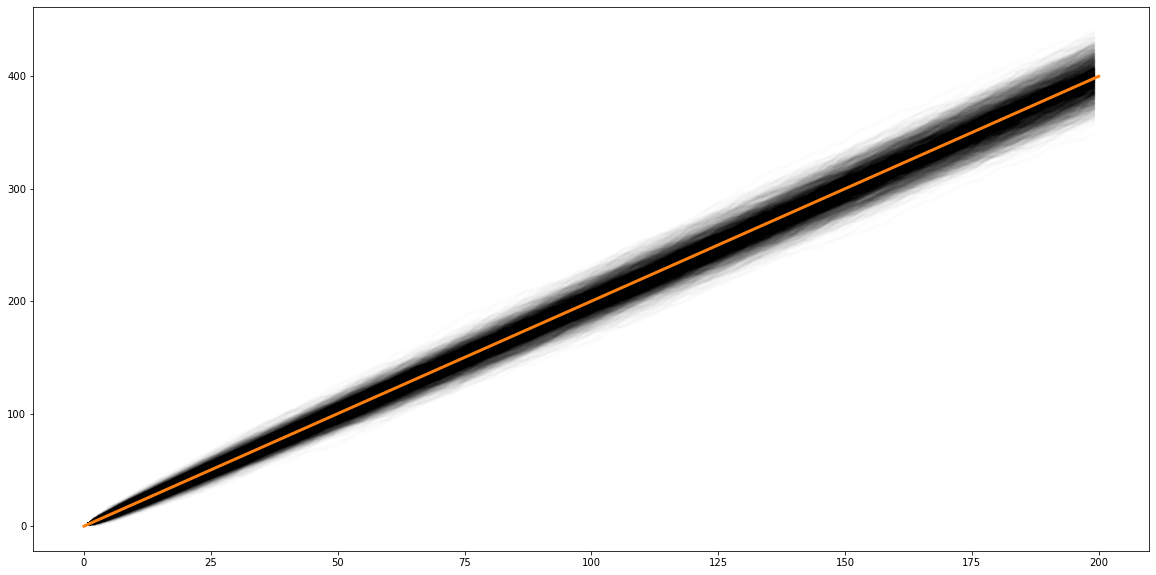

In [7]:
fig, ax = plt.subplots(figsize = (20,10))
for i in simulations:   
    data = simulations[[i]][1:]
    data["Predictor"] = results[i].predict()
    data["Predictor"].plot.line(color = "k", alpha = .01, linewidth = 3, ls = "-", ax = ax)#, label = "y-hat")
    #     x = np.linspace(list(simulations[i].index).iloc[0]), list(simulations[i].index).iloc[-1], periods - 1)
#     y = val["Intercept"] + val[i + ".shift(1)"] * x
#     ax.plot(x, y, color = "k", alpha = .01, linewidth = 3, ls = "-")#, label = "y-hat")
x = np.linspace(0, periods, periods)
y = 0 + e_bar * x
ax.plot(x,y, color = "C1", linewidth = 3)


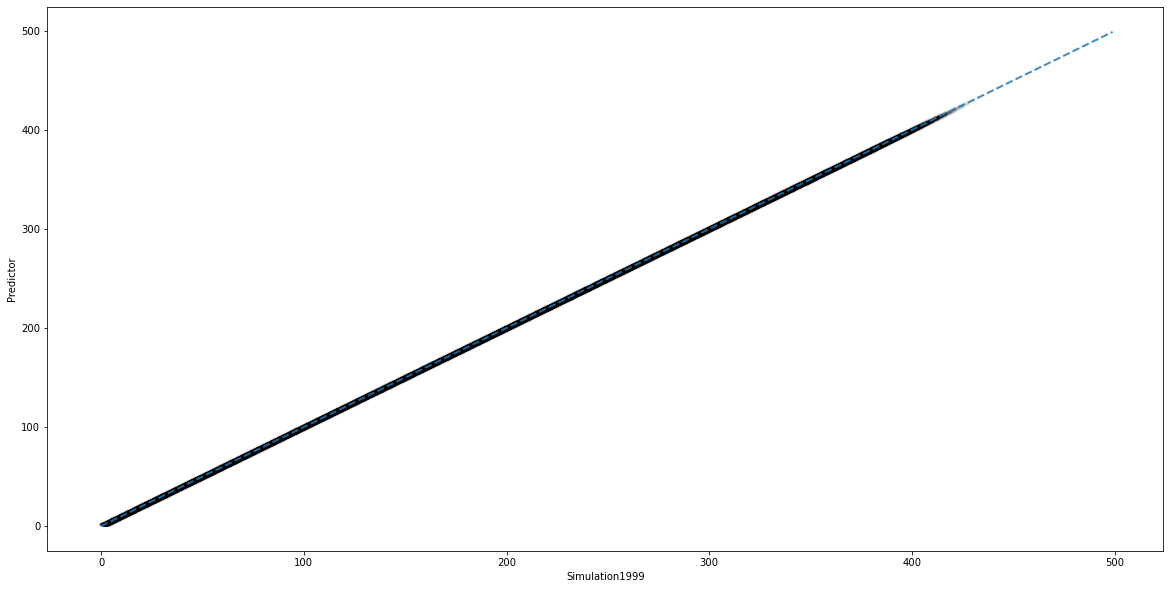

In [8]:
fig, ax = plt.subplots(figsize = (20,10))
for i in simulations:   
    data = simulations[[i]][1:]
    data["Predictor"] = results[i].predict()
    data.plot.scatter(x = i, y = "Predictor", alpha = .005, s = 10, ax = ax, color = "k")
ax.plot(np.arange(max(ax.get_xticks())), linewidth = 2, ls = "--", alpha = .85)

## Differences of Highly Persistent Time Series


In [9]:
sim_diff = simulations.diff().dropna()
sim_diff

,Simulation0,Simulation1,Simulation2,Simulation3,Simulation4,Simulation5,Simulation6,Simulation7,Simulation8,Simulation9,...,Simulation1990,Simulation1991,Simulation1992,Simulation1993,Simulation1994,Simulation1995,Simulation1996,Simulation1997,Simulation1998,Simulation1999
1,0.795441,0.860394,2.610519,0.772404,0.949685,2.680446,2.603616,3.200110,2.081175,1.235662,...,4.922833,2.450021,2.113474,2.425615,2.823165,1.835270,4.309188,1.513663,3.370445,1.615352
2,3.458807,3.743345,1.485908,1.901549,2.089361,2.298923,2.717432,2.012295,1.914953,1.820954,...,1.857112,-0.823441,1.193012,2.304700,2.500164,1.721899,1.158858,2.387311,1.759467,1.522857
3,0.148313,0.778311,2.311689,2.955087,1.855188,1.369631,3.816412,2.448421,2.572223,3.408954,...,4.085048,1.264852,2.045431,2.969818,1.969746,2.070128,1.881590,1.721185,0.749276,-0.170551
4,1.963895,1.293101,1.616939,3.163385,2.020820,1.692039,0.624279,1.900396,0.045392,0.601887,...,1.070973,3.658570,2.683452,0.907991,3.538662,1.857950,0.886201,0.845028,0.853633,1.822579
5,0.769550,4.901223,2.762612,1.063039,0.692210,3.695685,1.878721,3.156732,0.996527,3.767509,...,2.423278,0.160791,3.571690,1.912219,2.064335,1.101121,2.336914,0.339782,3.533971,1.169870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2.820095,2.291866,-0.772467,1.867085,2.342381,2.466134,2.797023,1.538238,0.492804,0.628812,...,3.085067,3.179468,-0.457238,-0.176037,2.820739,1.523053,2.839042,1.424598,1.750463,0.489519
196,1.595577,3.703268,2.131402,2.242336,-0.794948,1.763358,1.904907,0.806970,1.087693,3.781451,...,0.174731,1.637347,2.492071,1.969856,1.322843,2.687810,3.006626,0.797393,2.441873,1.538284
197,2.131274,2.573009,3.127120,3.100031,2.778483,0.293270,2.522275,1.091909,1.109172,1.797313,...,1.279195,2.254911,2.672330,-0.193293,2.059689,1.908373,2.900508,2.863127,3.304537,1.056811
198,2.521650,1.385418,2.290703,2.572164,2.531440,0.949118,2.252864,1.034742,1.597609,2.489105,...,2.991922,2.692901,1.931071,4.195193,2.204090,0.891313,2.313009,3.409660,0.437788,-0.207938


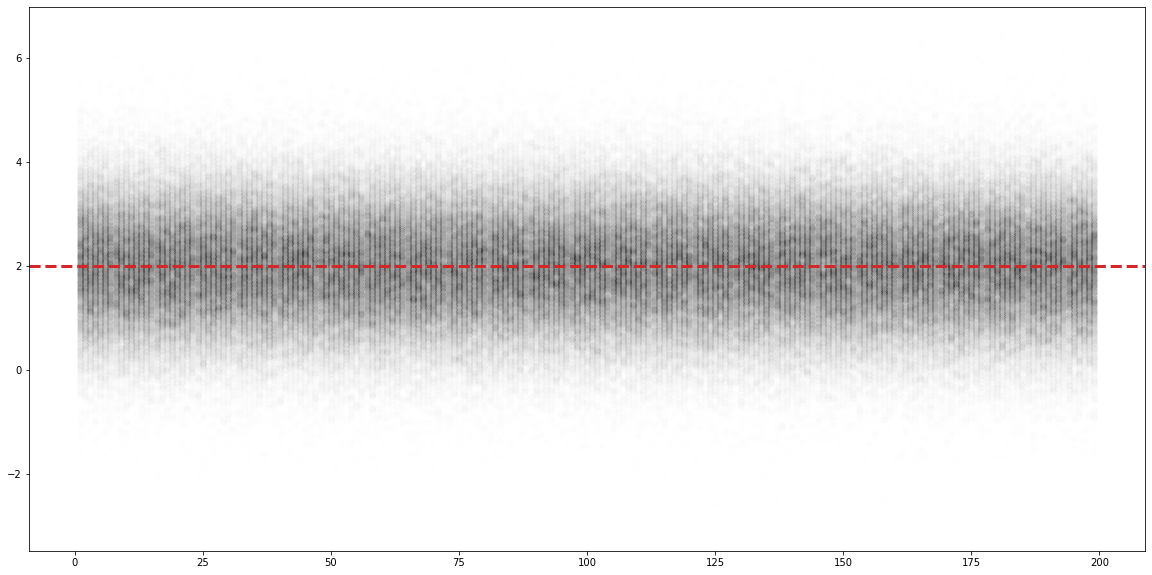

In [10]:
fig, ax = plt.subplots(figsize = (20,10))
sim_diff.plot.line(alpha = .002,
                             ls = " ",
                             marker = "o",
                             markersize = 6,
                             color = "k",
                      ax = ax, 
                      legend = False)
ax.axhline(e_bar, ls = "--", color = "C3", linewidth = 3)


In [11]:
count_sig = 0
p_val = 0.05
for i in sim_diff:
    formula = i + " ~ " + i + ".shift(1) + 1"
    reg = smf.ols(formula = formula,
        data =sim_diff)
    results[i] = reg.fit()
    summary = OLS_summary(results[i])
    if summary.iloc[1]["$$P>|t|$$"] <= p_val:
        count_sig += 1 

# compare number of statistically significant estimates to the asserted p_val
count_sig / len(sim_diff.keys())

0.044

In [12]:
count_sig

88

### Testing for Serial Correlation: Testing Phillip Curve for Reversion to Natural Rate (Mean Reversion)

#### Regress lag of error against error

$$\hat{u_t} = \hat{\rho}\hat{u_{t-1}}+ k$$

In [13]:
phillips = woo.dataWoo("phillips")
periods = len(phillips.index)

# define yearly time series index
pd.to_datetime(phillips["year"])
phillips.set_index("year", inplace = True)
yt96 = phillips.index <= 1996
formula = "Q('inf') ~ unem"
reg_s = smf.ols(formula = formula,
               data = phillips,
               subset = yt96)
results_s = reg_s.fit()
OLS_summary(results_s)

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.0527$$,,,,
Intercept,1.4236,0.8282,0.4118,1.7190
unem,0.4676,1.6174,0.1125,0.2891


['Intercept', 'unem']
Q('inf')


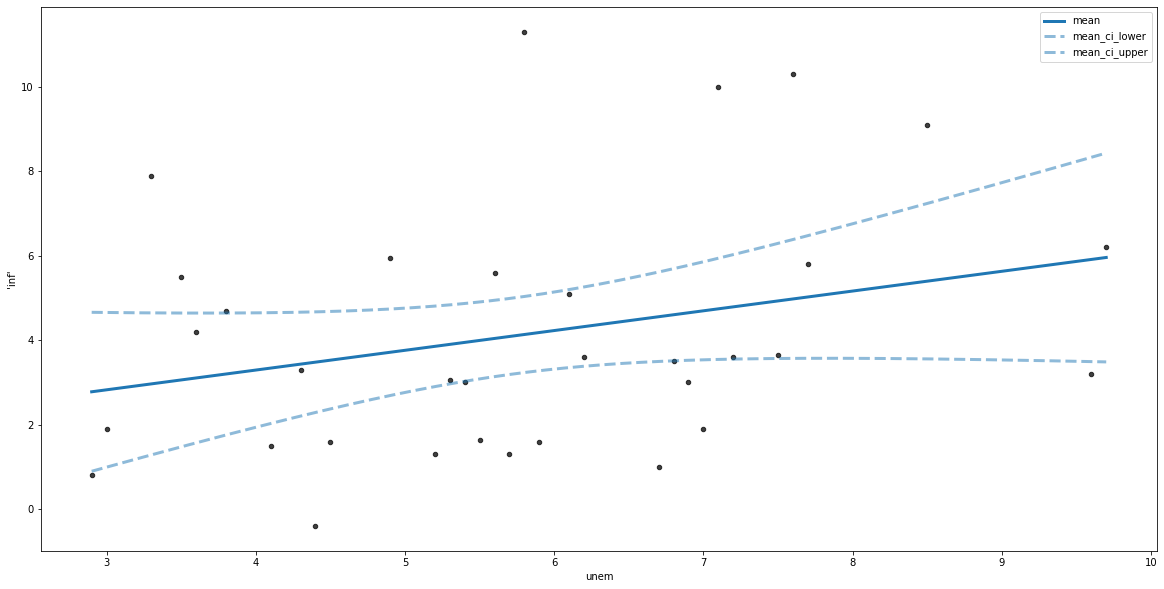

In [14]:
build_estimator(phillips, results_s, "Q('inf')")
build_smooth_multiple_regression_estimator(reg_s, phillips)

In [15]:
# residuals and AR(1) test:
phillips["resid_s"] = results_s.resid
phillips["resid_s_lag1"] = phillips["resid_s"].shift() 
reg_df = phillips[["resid_s", "resid_s_lag1"]]
formula = "resid_s ~ resid_s_lag1 + 0"
reg = smf.ols(formula = formula,
             data = reg_df,
             subset = yt96)
results = reg.fit()
# for bivariate regression, the squareroot of r-squared 
# is the correlation between the variables 

print(results.rsquared ** .5, reg_df.corr().iloc[0][1])
OLS_summary(results)

0.5876936180647698 0.5882587556173747


,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.3454$$,,,,
resid_s_lag1,0.5727,4.9797,0.0,0.115


#### According to the t-statistic for $\hat{\rho}$, the estimated error term is serially correlated. 

#### We can also check the Durbin-Watson Statistic:

$$DW = \frac{\sum_{t=2}^{n}{(\hat{u}_t - \hat{u}_{t-1})^2}}{\sum_{t=1}^{n}{\hat{u}_t^2}}$$

In [16]:
sm.stats.stattools.durbin_watson(results_s.resid)

0.802700467848626

In [17]:
sm.stats.diagnostic.acorr_breusch_godfrey(results, nlags = 1)

(5.356006336085807,
 0.020651013085524358,
 5.651911880721935,
 0.021747051510411165)

['resid_s_lag1']
resid_s


C:\Users\JLCat\GithubRepositories\Learn-Python-for-Stats-and-Econ\Projects\Graduate Macro Notebooks\supplementaryFunctions.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["$$\widehat{" + y_name + "}$$"] = results.fittedvalues
C:\Users\JLCat\GithubRepositories\Learn-Python-for-Stats-and-Econ\Projects\Graduate Macro Notebooks\supplementaryFunctions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["$$\hat{u}$$"] = results.resid


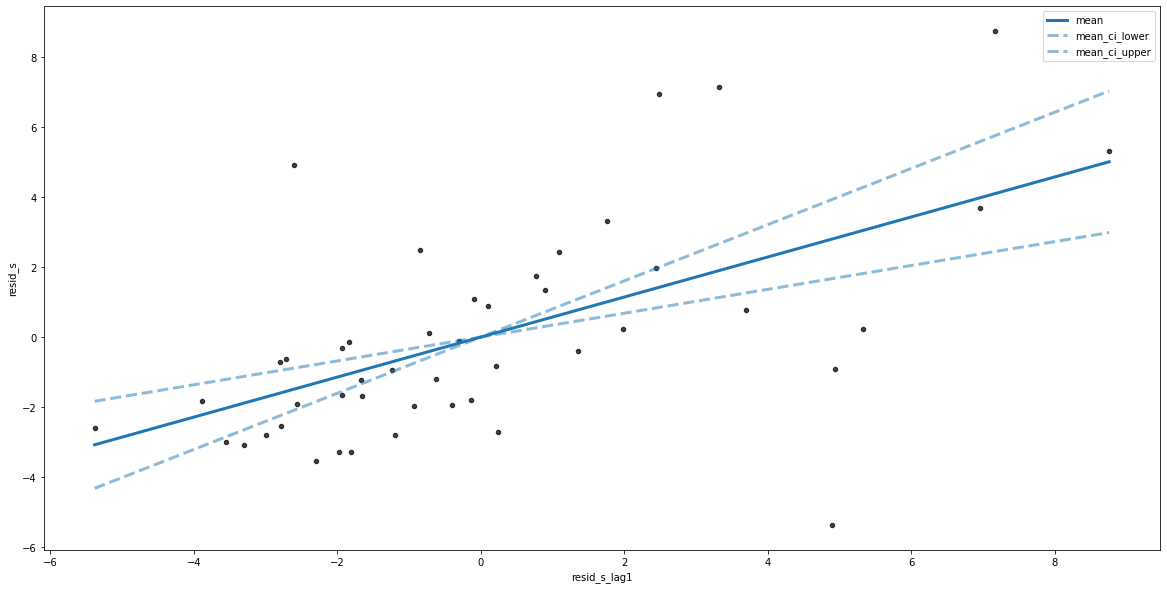

In [18]:
build_estimator(reg_df, results_s, "resid_s")
build_smooth_multiple_regression_estimator(reg, reg_df)

In [19]:
# probably most accurate model

formula = "unem ~ Q('inf') + 1"
reg_s = smf.ols(formula = formula,
               data = phillips.diff(),
               subset = yt96)
results_s = reg_s.fit()
OLS_summary(results_s)


,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.135$$,,,,
Intercept,0.0163,0.1071,0.9152,0.1521
Q('inf'),-0.1604,-2.6799,0.0102,0.0598


In [20]:
# probably most accurate model

formula = "unem ~ Q('inf') + Q('inf').shift() + 0"
reg_s = smf.ols(formula = formula,
               data = phillips.diff(),
               subset = yt96)
results_s = reg_s.fit()
OLS_summary(results_s)


,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.1351$$,,,,
Q('inf'),-0.1338,-1.9538,0.0570,0.0685
Q('inf').shift(),0.1027,1.7659,0.0842,0.0582


In [21]:
hac_results = reg_s.fit(cov_type="HAC", cov_kwds={"maxlags":1})
OLS_summary(hac_results)

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.1351$$,,,,
Q('inf'),-0.1338,-2.2195,0.0265,0.0603
Q('inf').shift(),0.1027,1.3189,0.1872,0.0779


In [22]:
# residuals and AR(1) test:
phillips["resid_s"] = results_s.resid
phillips["resid_s_lag1"] = phillips["resid_s"].shift() 
formula = "resid_s ~ resid_s_lag1"
reg = smf.ols(formula = formula,
             data = phillips,
             subset = yt96)
results = reg.fit()
OLS_summary(results)

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.0016$$,,,,
Intercept,-0.0011,-0.0073,0.9942,0.1519
resid_s_lag1,-0.0402,-0.2682,0.7898,0.1500
